# 9.7. 序列到序列学习（seq2seq）
正如我们在[9.5节](./L9_5_机器翻译与数据集.ipynb)中看到的， 机器翻译中的输入序列和输出序列都是长度可变的。 为了解决这类问题，我们在[9.6节](./L9_6_编码器-解码器架构.ipynb)中 设计了一个通用的”编码器－解码器“架构。 本节，我们将使用两个循环神经网络的编码器和解码器， 并将其应用于**序列到序列**（sequence to sequence，seq2seq）类的学习任务 [Cho et al., 2014b, Sutskever et al., 2014]。

遵循编码器－解码器架构的设计原则，循环神经网络编码器使用长度可变的序列作为输入，将其转换为固定形状的隐状态。换言之，**输入序列的信息被编码到循环神经网络编码器的隐状态中**。为了连续生成输出序列的词元，**独立的循环神经网络解码器是基于输入序列的编码信息和输出序列已经看见的或者生成的词元来预测下一个词元**。

下图演示了如何在机器翻译中使用两个循环神经网络进行序列到序列学习。

![avatar](../img/9_12.png)

在上图中， 特定的“\<eos>”表示序列结束词元。一旦输出序列生成此词元，模型就会停止预测。

在循环神经网络解码器的初始化时间步，有两个特定的设计决定：首先，特定的“\<bos>”表示序列开始词元，它是解码器的输入序列的第一个词元。其次，使用循环神经网络编码器最终的隐状态来初始化解码器的隐状态。例如，在 [Sutskever et al., 2014]的设计中， 正是基于这种设计将输入序列的编码信息送入到解码器中来生成输出序列的。

在其他一些设计中 [Cho et al., 2014b]，如上图所示，编码器最终的隐状态在每一个时间步都作为解码器的输入序列的一部分。类似于[8.3节](../chap8_RecurrentNruralNetwork/L8_3_语言模型和数据集.ipynb)中语言模型的训练，可以允许标签成为原始的输出序列，从源序列词元“\<bos>”、“Ils”、“regardent”、“.” 到新序列词元 “Ils”、“regardent”、“.”、“\<eos>”来移动预测的位置。

下面，我们动手构建上图的设计，并将基于[9.5节](./L9_5_机器翻译与数据集.ipynb)中介绍的“英－法”数据集来训练这个机器翻译模型。


## 9.7.1. 编码器
从技术上讲，编码器**将长度可变的输入序列转换成形状固定的上下文变量$\mathbf{c}$，并且将输入序列的信息在该上下文变量中进行编码**。

如上图所示，可以使用循环神经网络来设计编码器。

考虑由一个序列组成的样本（批量大小是$1$）。假设输入序列是$x_1, \ldots, x_T$，其中$x_t$是输入文本序列中的第$t$个词元。在时间步$t$，循环神经网络将词元$x_t$的输入特征向量$\mathbf{x}_t$和$\mathbf{h} _{t-1}$（即上一时间步的隐状态）转换为$\mathbf{h}_t$（即当前步的隐状态）。使用一个函数$f$来描述循环神经网络的循环层所做的变换：

$$\mathbf{h}_t = f(\mathbf{x}_t, \mathbf{h}_{t-1}). \tag{9.7.1}$$

总之，编码器通过选定的函数$q$，将所有时间步的隐状态转换为上下文变量：

$$\mathbf{c} =  q(\mathbf{h}_1, \ldots, \mathbf{h}_T). \tag{9.7.2}$$

比如，当选择$q(\mathbf{h}_1, \ldots, \mathbf{h}_T) = \mathbf{h}_T$时（就像上图一样），上下文变量仅仅是输入序列在最后时间步的隐状态$\mathbf{h}_T$。

到目前为止，我们使用的是一个单向循环神经网络来设计编码器，其中隐状态只依赖于输入子序列，这个子序列是由输入序列的开始位置到隐状态所在的时间步的位置（包括隐状态所在的时间步）组成。我们也可以使用双向循环神经网络构造编码器，其中隐状态依赖于两个输入子序列，两个子序列是由隐状态所在的时间步的位置之前的序列和之后的序列（包括隐状态所在的时间步），因此隐状态对整个序列的信息都进行了编码。

现在，让我们**实现循环神经网络编码器**。注意，我们使用了**嵌入层**（embedding layer）来**获得输入序列中每个词元的特征向量**。嵌入层的权重是一个矩阵，其行数等于输入词表的大小（`vocab_size`），其列数等于特征向量的维度（`embed_size`）。对于任意输入词元的索引$i$，嵌入层获取权重矩阵的第$i$行（从$0$开始）以返回其特征向量。另外，本文选择了一个多层门控循环单元来实现编码器。

In [1]:

import collections
import math
import torch
from torch import nn
from d2l import torch as d2l

"""
用于序列到序列学习的循环神经网络编码器
"""
#@save
class Seq2SeqEncoder(d2l.Encoder):
    def __init__(self,vocab_size,embed_size,num_hiddens,num_layers,dropout=0,**kwargs):
        super(Seq2SeqEncoder,self).__init__(**kwargs)

        # 嵌入层
        self.embedding = nn.Embedding(num_embeddings=vocab_size,
                                      embedding_dim=embed_size)

        self.rnn = nn.GRU(input_size=embed_size,
                          hidden_size=num_hiddens,
                          num_layers=num_layers,
                          dropout=dropout)

    def forward(self,X,*args):

        # 输出'X'的形状：(batch_size,num_steps,embed_size)
        X = self.embedding(X)

        # 将tensor的维度换位
        # permute相当于可以同时操作于tensor的若干维度，transpose只能同时作用于tensor的两个维度；
        X = X.permute(1,0,2)  # 在循环神经网络模型中，第一个轴对应于时间步

        # 如果未提及状态，则默认为0
        output,state = self.rnn(X)

        # output的形状:(num_steps,batch_size,num_hiddens)
        # state的形状:(num_layers,batch_size,num_hiddens)
        return output,state  # 循环层返回变量的说明可以参考 8.6节。


In [5]:
"""
下面，我们实例化上述编码器的实现：我们使用一个两层门控循环单元编码器，其隐藏单元数为16。

给定一小批量的输入序列X（批量大小为4，时间步为7）。

在完成所有时间步后， 最后一层的隐状态的输出是一个张量（output由编码器的循环层返回），其形状为（时间步数，批量大小，隐藏单元数）。
"""
encoder=Seq2SeqEncoder(vocab_size=10,
                       embed_size=8,
                       num_hiddens=16,
                       num_layers=2)

encoder.eval()  # eval模式，dropout不会生效



Seq2SeqEncoder(
  (embedding): Embedding(10, 8)
  (rnn): GRU(8, 16, num_layers=2)
)

In [3]:
# 4：batchSize
# 7：句子长度(单词数量)
X = torch.zeros((4,7),dtype=torch.long)
X,X.shape

(tensor([[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0]]),
 torch.Size([4, 7]))

In [6]:

output, state = encoder(X)

# 7：每一个时刻
# torch.Size([7, 4, 16])
output,output.shape

(tensor([[[ 6.6411e-02,  5.7679e-02, -1.3977e-01, -4.1847e-02,  1.2777e-01,
            6.9266e-02, -5.5810e-03,  9.0435e-02, -1.0029e-01, -2.0597e-01,
            4.1847e-04, -9.1146e-02,  4.2902e-02, -3.0183e-02,  3.5628e-02,
            2.8127e-03],
          [ 6.6411e-02,  5.7679e-02, -1.3977e-01, -4.1847e-02,  1.2777e-01,
            6.9266e-02, -5.5810e-03,  9.0435e-02, -1.0029e-01, -2.0597e-01,
            4.1847e-04, -9.1146e-02,  4.2902e-02, -3.0183e-02,  3.5628e-02,
            2.8127e-03],
          [ 6.6411e-02,  5.7679e-02, -1.3977e-01, -4.1847e-02,  1.2777e-01,
            6.9266e-02, -5.5810e-03,  9.0435e-02, -1.0029e-01, -2.0597e-01,
            4.1847e-04, -9.1146e-02,  4.2902e-02, -3.0183e-02,  3.5628e-02,
            2.8127e-03],
          [ 6.6411e-02,  5.7679e-02, -1.3977e-01, -4.1847e-02,  1.2777e-01,
            6.9266e-02, -5.5810e-03,  9.0435e-02, -1.0029e-01, -2.0597e-01,
            4.1847e-04, -9.1146e-02,  4.2902e-02, -3.0183e-02,  3.5628e-02,
            2

In [4]:
"""
由于这里使用的是门控循环单元，所以在最后一个时间步的多层隐状态的形状是（隐藏层的数量，批量大小，隐藏单元的数量）。

如果使用长短期记忆网络，state中还将包含记忆单元信息。
"""

# 2：两层
state.shape

torch.Size([2, 4, 16])

## 9.7.2. 解码器
正如上文提到的，编码器输出的上下文变量$\mathbf{c}$对整个输入序列$x_1, \ldots, x_T$进行编码。来自训练数据集的输出序列$y_1, y_2, \ldots, y_{T'}$，对于每个时间步$t'$（与输入序列或编码器的时间步$t$不同），解码器输出$y_{t'}$的概率取决于先前的输出子序列$y_1, \ldots, y_{t'-1}$和上下文变量$\mathbf{c}$，即$P(y_{t'} \mid y_1, \ldots, y_{t'-1}, \mathbf{c})$。

为了在序列上模型化这种条件概率，我们可以使用另一个循环神经网络作为解码器。在输出序列上的任意时间步$t^\prime$，循环神经网络将来自上一时间步的输出$y_{t^\prime-1}$和上下文变量$\mathbf{c}$作为其输入，然后在当前时间步将它们和上一隐状态$\mathbf{s}_{t^\prime-1}$转换为隐状态$\mathbf{s}_{t^\prime}$。因此，可以使用函数$g$来表示解码器的隐藏层的变换：

$$\mathbf{s}_{t^\prime} = g(y_{t^\prime-1}, \mathbf{c}, \mathbf{s}_{t^\prime-1}).\tag{9.7.3}$$


在获得解码器的隐状态之后，我们可以使用输出层和softmax操作来计算在时间步$t^\prime$时输出$y_{t^\prime}$的条件概率分布$P(y_{t^\prime} \mid y_1, \ldots, y_{t^\prime-1}, \mathbf{c})$。

根据图9.7.1，当实现解码器时，我们直接使用编码器最后一个时间步的隐状态来初始化解码器的隐状态。这就要求使用循环神经网络实现的编码器和解码器具有相同数量的层和隐藏单元。为了进一步包含经过编码的输入序列的信息，上下文变量在所有的时间步与解码器的输入进行拼接（concatenate）。

为了预测输出词元的概率分布，在循环神经网络解码器的最后一层使用全连接层来变换隐状态。

In [5]:
class Seq2SeqDecoder(d2l.Decoder):
    """用于序列到序列学习的循环神经网络解码器"""
    def __init__(self,vocab_size,embed_size,num_hiddens,num_layers,dropout=0,**kwargs):
        super(Seq2SeqDecoder,self).__init__(**kwargs)

        self.embedding = nn.Embedding(vocab_size,embed_size)

        self.rnn = nn.GRU(embed_size + num_hiddens,
                        num_hiddens,
                        num_layers,
                        dropout=dropout)

        self.dense = nn.Linear(num_hiddens,vocab_size)

    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]

    def forward(self, X, state):
        # 输出'X'的形状：(batch_size,num_steps,embed_size)
        X=self.embedding(X).permute(1,0,2)

        # 广播context，使其具有与X相同的num_steps
        # state[-1]：最后一层的最后时刻的输出
        context = state[-1].repeat(X.shape[0],1,1)


        X_and_context=torch.cat((X,context),2)

        output,state=self.rnn(X_and_context,state)

        output=self.dense(output).permute(1,0,2)
        # output的形状:(batch_size,num_steps,vocab_size)
        # state的形状:(num_layers,batch_size,num_hiddens)
        return output,state

In [6]:
"""
下面，我们用与前面提到的编码器中相同的超参数来实例化解码器。

如我们所见，解码器的输出形状变为（批量大小，时间步数，词表大小）， 其中张量的最后一个维度存储预测的词元分布。
"""
decoder = Seq2SeqDecoder(vocab_size=10,
                         embed_size=8,
                         num_hiddens=16,
                         num_layers=2)
decoder.eval()
state = decoder.init_state(encoder(X))

output,state = decoder(X,state)

output.shape,state.shape

(torch.Size([4, 7, 10]), torch.Size([2, 4, 16]))

上述循环神经网络“编码器－解码器”模型中的各层如下图所示。
![avatar](../img/9_13.png)

## 9.7.3. 损失函数
在每个时间步，解码器预测了输出词元的概率分布。类似于语言模型，可以使用softmax来获得分布，并通过计算**交叉熵损失函数**来进行优化。回想一下[9.5节](./L9_5_机器翻译与数据集.ipynb)中，特定的填充词元被添加到序列的末尾，因此不同长度的序列可以以相同形状的小批量加载。但是，我们应该将填充词元的预测排除在损失函数的计算之外。


In [15]:
"""
为此，我们可以使用下面的sequence_mask函数通过零值化屏蔽不相关的项，以便后面任何不相关预测的计算都是与零的乘积，结果都等于零。

例如，如果两个序列的有效长度（不包括填充词元）分别为1和2，则第一个序列的第一项和第二个序列的前两项之后的剩余项将被清除为零。
"""

#@save
def sequence_mask(X,valid_len,value=0):
    """在序列中屏蔽不相关的项"""
    maxlen = X.size(1)

    mask = torch.arange((maxlen),dtype=torch.float32,device=X.device)[None,:] < valid_len[:,None]

    X[~mask] = value

    return X

X = torch.tensor([[1,2,3],[4,5,6]])

sequence_mask(X,torch.tensor([1,2]))

tensor([[1, 0, 0],
        [4, 5, 0]])

In [8]:
"""
我们还可以使用此函数屏蔽最后几个轴上的所有项。

如果愿意，也可以使用指定的非零值来替换这些项。
"""
X = torch.ones(2,3,4)

sequence_mask(X,torch.tensor([1,2]),value=-1)

tensor([[[ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.]],

        [[ 1.,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.]]])

In [9]:
"""
现在，我们可以通过扩展softmax交叉熵损失函数来遮蔽不相关的预测。

最初，所有预测词元的掩码都设置为1。一旦给定了有效长度，与填充词元对应的掩码将被设置为0。

最后，将所有词元的损失乘以掩码，以过滤掉损失中填充词元产生的不相关预测。
"""
#@save
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    """带遮蔽的softmax交叉熵损失函数"""
    # pred的形状：(batch_size,num_steps,vocab_size)
    # label的形状：(batch_size,num_steps)
    # valid_len的形状：(batch_size,)
    def forward(self, pred,label,valid_len):
        weights = torch.ones_like(label)

        weights = sequence_mask(weights,valid_len)

        self.reduction = 'none'

        unweighted_loss = super(MaskedSoftmaxCELoss,self).forward(pred.permute(0,2,1),label)

        weighted_loss = (unweighted_loss*weights).mean(dim=1)

        return weighted_loss

"""
我们可以创建三个相同的序列来进行代码健全性检查， 然后分别指定这些序列的有效长度为4、2和0。

结果就是，第一个序列的损失应为第二个序列的两倍，而第三个序列的损失应为零。
"""
loss = MaskedSoftmaxCELoss()

# 3:BatchSize
# 4:时间长度
# 10:vocabSize
loss(torch.ones(3,4,10),torch.ones((3,4),dtype=torch.long),torch.tensor([4,2,0]))

tensor([2.3026, 1.1513, 0.0000])

## 9.7.4. 训练
在下面的循环训练过程中，如 图9.7.1所示，特定的序列开始词元（“\<bos>”）和 原始的输出序列（不包括序列结束词元“\<eos>”） 拼接在一起作为解码器的输入。这被称为**强制教学**（teacher forcing），因为原始的输出序列（词元的标签）被送入解码器。或者，将来自上一个时间步的预测得到的词元作为解码器的当前输入。

In [10]:
#@save
def train_seq2seq(net,data_iter,lr,num_epochs,tgt_vocab,device):
    """训练序列到序列的模型"""
    def xavier_init_weights(m):
        if type(m)==nn.Linear:
            nn.init.xavier_normal_(m.weight)

        if type(m)==nn.GRU:
            for param in m._flat_weights_names:
                if 'weight' in param:
                    nn.init.xavier_uniform_(m._parameters[param])

    net.apply(xavier_init_weights)
    net.to(device)

    optimizer = torch.optim.Adam(net.parameters(),lr=lr)
    loss = MaskedSoftmaxCELoss()
    net.train()

    animator=d2l.Animator(xlabel='epoch',ylabel='loss',xlim=[10,num_epochs])

    for epoch in range(num_epochs):
        timer=d2l.Timer()
        metric=d2l.Accumulator(2)  # ；训练损失总和，词元数量
        for batch in data_iter:
            optimizer.zero_grad()
            X,X_valid_len,Y,Y_valid_len=[x.to(device) for x in batch]

            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],device=device ).reshape(-1,1)

            dec_input=torch.cat([bos,Y[:,:-1]],1)  # 强制教学

            Y_hat, _ = net(X,dec_input,X_valid_len)

            l = loss(Y_hat,Y,Y_valid_len)
            l.sum().backward()  # 损失函数的标量进行“反向传播”

            d2l.grad_clipping(net,1)

            num_tokens=Y_valid_len.sum()

            optimizer.step()

            with torch.no_grad():
                metric.add(l.sum(),num_tokens)
        if (epoch+1)%10 == 0:
            animator.add(epoch+1,(metric[0] / metric[1],))

        animator.show()

    print(f'loss {metric[0]/metric[1]:.3f}, {metric[1]/timer.stop():.1f},token/sec on {str(device)}')


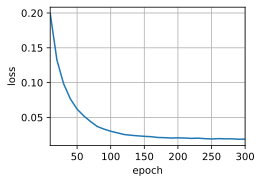

loss 0.019,24370.7,token/sec on cuda:0


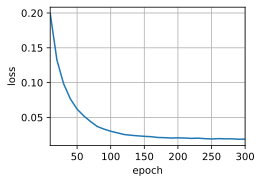

In [11]:

"""
现在，在机器翻译数据集上，我们可以创建和训练一个循环神经网络“编码器－解码器”模型用于序列到序列的学习。
"""
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1

# num_steps:句子长度
batch_size, num_steps = 64,10

lr, num_epochs, device = 0.005, 300, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size,num_steps)

encoder = Seq2SeqEncoder(len(src_vocab),embed_size,num_hiddens,num_layers,dropout)

decoder = Seq2SeqDecoder(len(tgt_vocab),embed_size,num_hiddens,num_layers,dropout)

net = d2l.EncoderDecoder(encoder,decoder)

train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

## 9.7.5. 预测
为了采用一个接着一个词元的方式预测输出序列，每个解码器当前时间步的输入都将来自于前一时间步的预测词元。与训练类似，序列开始词元（“\<bos>”） 在初始时间步被输入到解码器中。 该预测过程如图9.7.3所示，当输出序列的预测遇到序列结束词元（“\<eos>”）时，预测就结束了。

![](../img/9_14.png)

我们将在 9.8节中介绍不同的序列生成策略。

In [12]:
"""
序列到序列模型的预测
- 将上一步的预测作为下一步的输出
"""

#@save
def predict_seq2seq(net,src_sentence,src_vocab,tgt_vocab,num_steps,device,save_attention_weights=False):

    net.eval()  # 在预测时将net设置为评估模式

    src_tokens = src_vocab[src_sentence.lower().split(' ')]+[src_vocab['<eos>']]

    enc_valid_len = torch.tensor([len(src_tokens)],device=device)

    src_tokens = d2l.truncate_pad(src_tokens,num_steps,src_vocab['<pad>'])

    # 添加批量轴
    enc_X = torch.unsqueeze(torch.tensor(src_tokens,dtype=torch.long,device=device),dim=0)

    enc_outputs = net.encoder(enc_X,enc_valid_len)

    dec_state = net.decoder.init_state(enc_outputs,enc_valid_len)

    # 添加批量轴
    dec_X = torch.unsqueeze(torch.tensor([tgt_vocab['<bos>']],
                                         dtype=torch.long,
                                         device=device),dim=0)

    output_seq,attention_weight_seq=[],[]

    for _ in range(num_steps):
        Y,dec_state = net.decoder(dec_X,dec_state)

        # 我们使用具有预测最高可能性的词元，作为解码器在下一时间步的输入
        dec_X = Y.argmax(dim=2)
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()

        # 保存注意力权重（稍后讨论）
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)

        # 一旦序列结束词元被预测，输出序列的生成就完成了
        if pred==tgt_vocab['<eos>']:
            break
        output_seq.append(pred)

    return ' '.join(tgt_vocab.to_tokens(output_seq)),attention_weight_seq

## 9.7.6. 预测序列的评估
我们可以通过与真实的标签序列进行比较来评估预测序列。虽然`Papineni.Roukos.Ward.ea.2002`提出的**BLEU**（bilingual evaluation understudy）最先是用于评估机器翻译的结果，但现在它已经被广泛用于测量许多应用的输出序列的质量。原则上说，对于预测序列中的任意$n$元语法（n-grams），BLEU的评估都是这个$n$元语法是否出现在标签序列中。

我们将BLEU定义为：

$$ \exp\left(\min\left(0, 1 - \frac{\mathrm{len}_{\text{label}}}{\mathrm{len}_{\text{pred}}}\right)\right) \prod_{n=1}^k p_n^{1/2^n},  \tag{9.7.4}$$


其中$\mathrm{len}_{\text{label}}$表示标签序列中的词元数和$\mathrm{len}_{\text{pred}}$表示预测序列中的词元数，$k$是用于匹配的最长的$n$元语法。另外，用$p_n$表示$n$元语法的精确度，它是两个数量的比值：第一个是预测序列与标签序列中匹配的$n$元语法的数量，第二个是预测序列中$n$元语法的数量的比率。具体地说，给定标签序列$A$、$B$、$C$、$D$、$E$、$F$和预测序列$A$、$B$、$B$、$C$、$D$，我们有$p_1 = 4/5$、$p_2 = 3/4$、$p_3 = 1/3$和$p_4 = 0$。

根据公式9.7.4中BLEU的定义，当预测序列与标签序列完全相同时，BLEU为$1$。此外，由于$n$元语法越长则匹配难度越大，所以BLEU为更长的$n$元语法的精确度分配更大的权重。具体来说，当$p_n$固定时，$p_n^{1/2^n}$会随着$n$的增长而增加（原始论文使用$p_n^{1/n}$）。而且，由于预测的序列越短获得的$p_n$值越高，所以公式9.7.4中乘法项之前的系数用于惩罚较短的预测序列。例如，当$k=2$时，给定标签序列$A$、$B$、$C$、$D$、$E$、$F$和预测序列$A$、$B$，尽管$p_1 = p_2 = 1$，惩罚因子$\exp(1-6/2) \approx 0.14$会降低BLEU。


In [13]:
"""
BLEU的代码实现如下。
"""
def bleu(pred_seq,label_seq,k):  #@save
    """计算BLEU"""
    pred_tokens,label_tokens = pred_seq.split(' '),label_seq.split(' ')

    len_pred,len_label = len(pred_tokens),len(label_tokens)

    score=math.exp(min(0,1-len_label/len_pred))

    for n in range(1,k+1):
        num_matches,label_subs = 0,collections.defaultdict(int)
        for i in range(len_label-n+1):
            label_subs[' '.join(label_tokens[i:i+n])] += 1
        for i in range(len_pred-n+1):
            if label_subs[' '.join(pred_tokens[i:i+n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i:i+n])] -= 1
        score *= math.pow(num_matches / (len_pred-n+1) , math.pow(0.5,n))
    return score

"""
最后，利用训练好的循环神经网络“编码器－解码器”模型，将几个英语句子翻译成法语，并计算BLEU的最终结果。
"""
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng,fra in zip(engs,fras):
    translation,attention_weight_seq = predict_seq2seq(net,eng,src_vocab,tgt_vocab,num_steps,device)
    print(f'{eng} => {translation},bleu {bleu(translation,fra,k=2):.3f}')

go . => va <unk> .,bleu 0.000
i lost . => j'ai perdu .,bleu 1.000
he's calm . => il est bon gagné maintenant .,bleu 0.473
i'm home . => je suis chez suis triste .,bleu 0.649


## 9.7.7. 小结
- 根据“编码器-解码器”架构的设计， 我们可以使用两个循环神经网络来设计一个序列到序列学习的模型。
- 在实现编码器和解码器时，我们可以使用多层循环神经网络。
- 我们可以使用遮蔽来过滤不相关的计算，例如在计算损失时。
- 在“编码器－解码器”训练中，强制教学方法将原始输出序列（而非预测结果）输入解码器。
- BLEU是一种常用的评估方法，它通过测量预测序列和标签序列之间的元语法的匹配度来评估预测。